# Co-planar waveguide in RF photonics part 2: segmented electrodes in a Mach-Zehnder modulator

**Note**: this notebook requires Tidy3D version 2.10.0rc1 or later.

The co-planar waveguide (CPW) is a transmission line commonly used in RF photonics due to its compact planar nature, ease of fabrication, and resistance to external EM interference. In this notebook series, we will examine the CPW in the context of a Mach-Zehnder modulator (MZM).

In [part one](https://www.flexcompute.com/tidy3d/examples/notebooks/CPWRFPhotonics1/), we started with a simple CPW on a dielectric substrate. The goal of the notebook is to demonstrate the typical 2D and 3D workflow in Tidy3D's RF solver. We also benchmarked key results against other commercial RF simulation software.

In part two (this notebook), we will simulate the CPW with the MZM optical waveguide. A 2D mode analysis will first be performed on the conventional straight CPW layout, followed by a 3D simulation of a segmented electrode design. The latter will be benchmarked against a commercial FEM code. 

The segmented electrode design aims to address two key shortcomings of the conventional CPW: velocity mismatch and metallic loss. It is formed by adding T-shaped metal electrodes to the gaps in a conventional CPW. The effective RF index can be tuned by changing the T-electrode geometry, thus allowing for ideal velocity matching between the electrical and optical signals. The T-electrodes also spread the RF surface current outwards away from the gap, effectively increasing conductor area and reducing overall loss. At the same time, the CPW gap remains narrow in order to maintain a strong RF field for optical modulation.

<center><img src="./img/cpw_rf_photonics_2_render.png" width=640/></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.microwave as mw
import tidy3d.plugins.smatrix as sm
from tidy3d.plugins.mode import ModeSolver

td.config.logging_level = "ERROR"

### Key Parameters and Mediums

We define some general model parameters below. The analysis bandwidth is between 1 and 65 GHz. 

In [2]:
# Frequency range
f_min, f_max = (1e9, 65e9)
f0 = (f_min + f_max) / 2
freqs = np.linspace(f_min, f_max, 101)

The material properties are defined below. The optical waveguide is made of thin-film lithium niobate (TFLN) with SiO2 cladding. The substrate is made of quartz. The metal CPW electrodes are made of gold. 

<center><img src="./img/cpw_rf_photonics_2_schematic1.png" width=800/></center>

The anisotropic TFLN is implemented with the `AnisotropicMedium` feature. 

We assume gold to be the only lossy medium in this study, as conductor losses typically dominate in the the bandwidth of interest. In order to implement constant loss over the frequency range, we use `LossyMetalMedium` which implements a surface impedance model (SIBC) with constant conductivity. 

In [3]:
# Mediums
med_air = td.Medium(permittivity=1, name="Air")
med_SiO2 = td.Medium(permittivity=3.8, name="SiO2")
med_Qz = td.Medium(permittivity=4.5, name="Quartz")
med_LN_o = td.Medium(permittivity=44, name="TFLN ord.")
med_LN_eo = td.Medium(permittivity=27.9, name="TFLN extraord.")
med_LN = td.AnisotropicMedium(xx=med_LN_eo, yy=med_LN_o, zz=med_LN_o, name="TFLN")
med_Au = td.LossyMetalMedium(conductivity=41, frequency_range=(f_min, f_max), name="Gold")

## Conventional MZM-CPW (2D Analysis)

### Geometry

In this section, we will construct a conventional CPW with a gap size of 5 um. The relevant geometry parameters are defined below. All lengths are in microns.

In [4]:
# Layer thicknesses
len_inf = 1e5  # effective infinity
tm = 1  # metal
tsio21 = 0.2  # SiO2 cladding layer
tsio20 = 2  # SiO2 BOX layer
tln0 = 0.6  # TFLN layer un-etched
tln1 = 0.3  # TFLN layer etched
tqz = len_inf  # substrate layer

# CPW dimensions
g = 5  # CPW gap
ws = 100  # Width of signal trace
wg = 300  # Width of ground trace
w_cpw = ws + 2 * (g + wg)  # Overall span of CPW

# TFLN optical waveguide dimensions
w0 = 1  # Core width
thetaln = 30 / 180 * np.pi  # Sidewall angle, radians
w1 = 1000  # Overall width of layers

We start by creating `Structure` instances for each dielectric material layer.

In [5]:
# Define dielectric layers
str_sio2_clad = td.Structure(
    medium=med_SiO2,
    geometry=td.Box(center=(0, 0, (tln0 - tln1) + tsio21 / 2.0), size=(w1, td.inf, tsio21)),
)
str_sio2_box = td.Structure(
    medium=med_SiO2, geometry=td.Box(center=(0, 0, -tsio20 / 2.0), size=(w1, td.inf, tsio20))
)
str_qz = td.Structure(
    medium=med_Qz,
    geometry=td.Box(center=(0, 0, -tqz / 2.0 + tsio20 / 2 - tm / 2), size=(w1, td.inf, tqz)),
)
str_ln_layer = td.Structure(
    medium=med_LN, geometry=td.Box(center=(0, 0, tln1 / 2.0), size=(w1, td.inf, tln1))
)
structures_layers = [str_qz, str_sio2_clad, str_sio2_box, str_ln_layer]

We use a user-defined function to create the CPW structures.

In [6]:
def create_cpw(gap, width, width_gnd, thickness, start, end):
    """create a centered cpw with specified parameters"""
    length = end - start
    midpos = (end + start) / 2
    str_c1 = td.Structure(
        medium=med_Au,
        geometry=td.Box(
            size=(width_gnd, length, thickness),
            center=(-width / 2 - gap - width_gnd / 2, midpos, tln0 - tln1 + tsio21 + tm / 2.0),
        ),
    )
    str_c2 = td.Structure(
        medium=med_Au,
        geometry=td.Box(
            size=(width_gnd, length, thickness),
            center=(width / 2 + gap + width_gnd / 2, midpos, tln0 - tln1 + tsio21 + tm / 2.0),
        ),
    )
    str_sig = td.Structure(
        medium=med_Au,
        geometry=td.Box(
            size=(width, length, thickness), center=(0, midpos, tln0 - tln1 + tsio21 + tm / 2.0)
        ),
    )
    return [str_c1, str_c2, str_sig]


# Create CPW structure
str_cpw_conventional = create_cpw(g, ws, wg, tm, -len_inf, len_inf)

The optical waveguide is also created using a parametrized function. 

In [7]:
def create_rib_structure(width, height, sidewall_angle, center, medium):
    """Create a pair of ribs with given top width, height, sidewall angle and center position (mirrored in x)"""
    x0, y0 = center
    geom1 = td.PolySlab(
        axis=2,
        sidewall_angle=sidewall_angle,
        reference_plane="top",
        slab_bounds=(y0 - height / 2, y0 + height / 2),
        vertices=[
            (x0 + width / 2, len_inf),
            (x0 - width / 2, len_inf),
            (x0 - width / 2, -len_inf),
            (x0 + width / 2, -len_inf),
        ],
    )
    geom2 = geom1.translated(-2 * x0, 0, 0)
    geoms = td.GeometryGroup(geometries=[geom1, geom2])
    return td.Structure(geometry=geoms, medium=medium)


# Create optical waveguide and cladding structure
str_optical_wg = create_rib_structure(
    w0, tln0 - tln1, thetaln, ((ws + g) / 2, tln0 - tln1 / 2.0), med_LN
)
str_optical_wg_clad = create_rib_structure(
    1.2 * w0, tln0 - tln1, thetaln, ((ws + g) / 2, tln0 - tln1 / 2.0 + tsio21), med_SiO2
)
structures_optical = [str_optical_wg_clad, str_optical_wg]

All structures are collected in a list.

In [8]:
structures_list_cpw_conventional = structures_layers + structures_optical + str_cpw_conventional

We can set up a test `Scene` to visualize the structures. 

In [9]:
test_scene = td.Scene(medium=med_air, structures=structures_list_cpw_conventional)

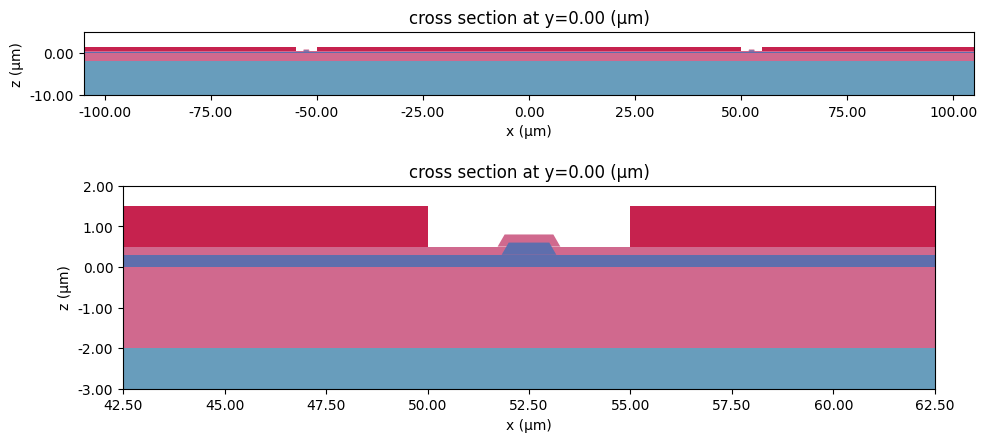

In [10]:
# Plot the test scene
ypos = 0
fig, ax = plt.subplots(2, 1, figsize=(10, 5), tight_layout=True)
test_scene.plot(y=ypos, hlim=(-g - ws, g + ws), vlim=(-10, 5), ax=ax[0])
ax[0].set_aspect(1)
test_scene.plot(y=ypos, hlim=((g + ws) / 2 - 10, (g + ws) / 2 + 10), vlim=(-3, 2), ax=ax[1])
plt.show()

### Grid and Boundary Conditions

The simulation domain is surrounded by Perfectly Matched Layers (PMLs) on all side by default. We add a quarter-wavelength padding on all sides to ensure that they do not encroach on the near-field. 

In [11]:
# Define simulation size
padding = td.C_0 / f_max / 4
sim_LX = w_cpw + 2 * padding
sim_LY = sim_LX
sim_LZ = sim_LX

We make use of `LayerRefinementSpec` to refine the grid near the metallic CPW structures. 

In [12]:
# Layer refinement around conductors
LR_spec_1 = td.LayerRefinementSpec.from_structures(
    structures=str_cpw_conventional,
    min_steps_along_axis=5,
    refinement_inside_sim_only=False,
    corner_refinement=td.GridRefinement(dl=tm / 5, num_cells=2),
)

Additionally, we will also define a mesh refinement box around the optical waveguide for more accurate results. 

In [13]:
# Mesh override structure around optical wavelength core
refine_box = td.MeshOverrideStructure(
    geometry=td.Box(center=((ws + g) / 2, 0, (tln1) / 2), size=(1.2 * w0, td.inf, (tln1))),
    dl=(w0 / 5.0, None, tln1 / 5.0),
)

The rest of the grid is automatically generated according to the wavelength. 

In [14]:
# Define overall grid specification
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f_max,
    min_steps_per_wvl=12,
    override_structures=[refine_box],
    layer_refinement_specs=[LR_spec_1],
)

### Wave Ports

Although we will not be running a 3D simulation in this section, we can nevertheless define a `WavePort` in order to facilitate the setup of the 2D mode analysis. The dummy wave port is defined below. 

In [15]:
# Wave port dimensions
wp_center = (0, 0, 1)
wp_size = (w_cpw - 15, 0, w_cpw - 15)

# Define current integration path (loop)
I_int = mw.CurrentIntegralAxisAligned(center=wp_center, size=(ws + g, 0, 5 * tm), sign="+")

# Define wave port
WP_dummy = sm.WavePort(
    center=wp_center,
    size=wp_size,
    mode_spec=td.ModeSpec(target_neff=np.sqrt(8)),
    direction="+",
    name="Dummy WP",
    current_integral=I_int,
)

### Mode Solver

As in the [first notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/CPWRFPhotonics1/), we will conduct a 2D mode analysis to obtain key transmission line parameters. 

In [16]:
# Define base mode solver simulation
ms_sim = td.Simulation(
    size=(sim_LX, sim_LY, sim_LZ),
    medium=med_air,
    grid_spec=grid_spec,
    structures=structures_list_cpw_conventional,
    symmetry=(1, 0, 0),
    run_time=1e-10,
)

# Define mode solver
mode_solver = WP_dummy.to_mode_solver(simulation=ms_sim, freqs=freqs)

Before running, let us preview the transverse grid near the optical waveguide to ensure that it is suitably refined. 

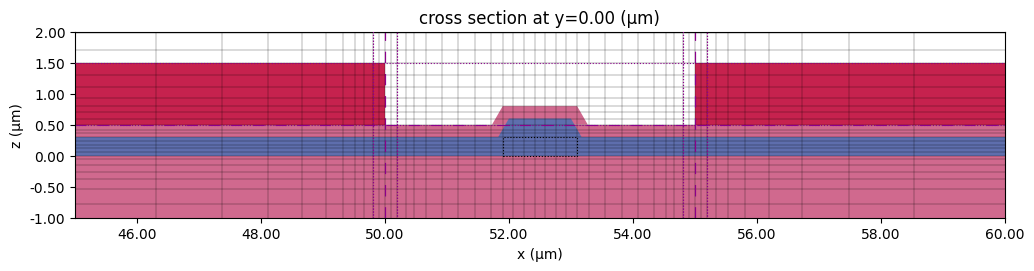

In [17]:
# Plot transverse grid
fig, ax = plt.subplots(figsize=(12, 4))
ms_sim.plot(y=0, ax=ax)
ms_sim.plot_grid(y=0, ax=ax, hlim=(ws / 2 - 5, ws / 2 + g + 5), vlim=(-1, 2))
plt.show()

We run the mode solver below. 

In [18]:
mode_data = td.web.run(mode_solver, task_name="mode solver", path="data/mode_data.hdf5")

10:14:14 EDT Created task 'mode solver' with resource_id                        
             'mo-b2d597ed-ce59-41cc-9a36-8f31b164734b' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=52901;https://tidy3d.simulation.cloud/workbench?taskId=mo-b2d597ed-ce59-41cc-9a36-8f31b164734b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=580537;https://tidy3d.simulation.cloud/workbench?taskId=mo-b2d597ed-ce59-41cc-9a36-8f31b164734b\taskId]8;;\]8;id=52901;https://tidy3d.simulation.cloud/workbench?taskId=mo-b2d597ed-ce59-41cc-9a36-8f31b164734b\=]8;;\]8;id=302957;https://tidy3d.simulation.cloud/workbench?taskId=mo-b2d597ed-ce59-41cc-9a36-8f31b164734b\mo]8;;\]8;id=52901;https://tidy3d.simulation.cloud/workbench?taskId=mo-b2d597ed-ce59-41cc-9a36-8f31b164734b\-b2d597ed-ce59-]8;;\
             ]8;id=52901;https://tidy3d.simulation.cloud/workbench?taskId=mo-b2d597ed-ce59-41cc-9a36-8f31b164734b\41cc-9a36-8f31b164734b']8;;\.

             Task folder: ]8;id=427086;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

10:14:16 EDT Estimated FlexCredit cost: 0.014. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = success

Output()

10:14:22 EDT loading simulation from data/mode_data.hdf5

### 2D Results

#### Mode Profile

The field magnitude profile in one of the CPW gaps is shown below. 

/Users/yuanshenli/Documents/GitHub/tidy3d/tidy3d-dev/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


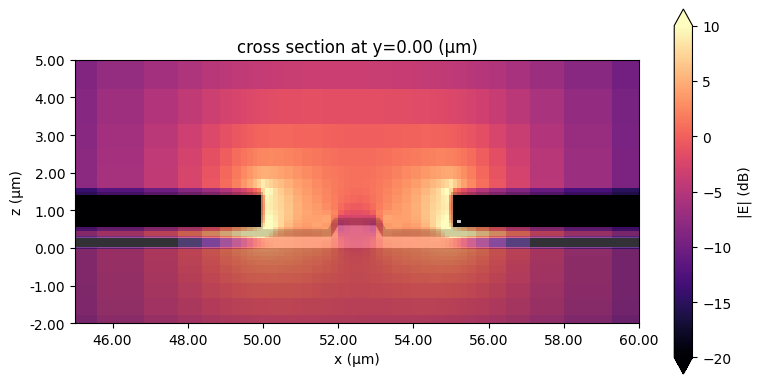

In [19]:
# Plot the mode field
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
mode_solver.plot_field(field_name="E", val="abs", scale="dB", f=40e9, ax=ax, vmax=10, vmin=-20)
ax.set_xlim(ws / 2 - 5, ws / 2 + g + 5)
ax.set_ylim(-2, 5)
plt.show()

#### Effective Index, Attenuation, and Characteristic Impedance

The key properties that determine a guided mode are effective index $n_\text{eff}$, attenuation $\alpha$, and characteristic impedance $Z_0$. We demonstrate how to obtain those values below. 

The first two quantities, $n_\text{eff}$ and $\alpha$, are computed directly by the mode solver. Below, we extract these values from the solution data and also use them to compute the complex propagation constant $\gamma = \beta + j\alpha$. 

In [20]:
# Gather alpha, neff from mode solver results
neff_mode = mode_data.modes_info["n eff"].squeeze()
alphadB_mode = mode_data.modes_info["loss (dB/cm)"].squeeze()

# Convert alpha from dB/cm to 1/um
alpha_mode = alphadB_mode / 8.686 / 1e4

# Calculate beta, gamma using neff and alpha
beta_mode = 2 * np.pi * freqs * neff_mode / td.C_0
gamma_mode = alpha_mode + 1j * beta_mode

The characteristic line impedance $Z_0$ is calculated using the `ImpedanceCalculator` utility class. Note the use of `np.conjugate()` to convert from the physics phase convention (used in Tidy3D) to the standard electrical engineering phase convention. 

In [21]:
# Calculate Z0
Z0_mode = np.conjugate(
    mw.ImpedanceCalculator(current_integral=I_int).compute_impedance(mode_data)
).squeeze()

These values are plotted below. 

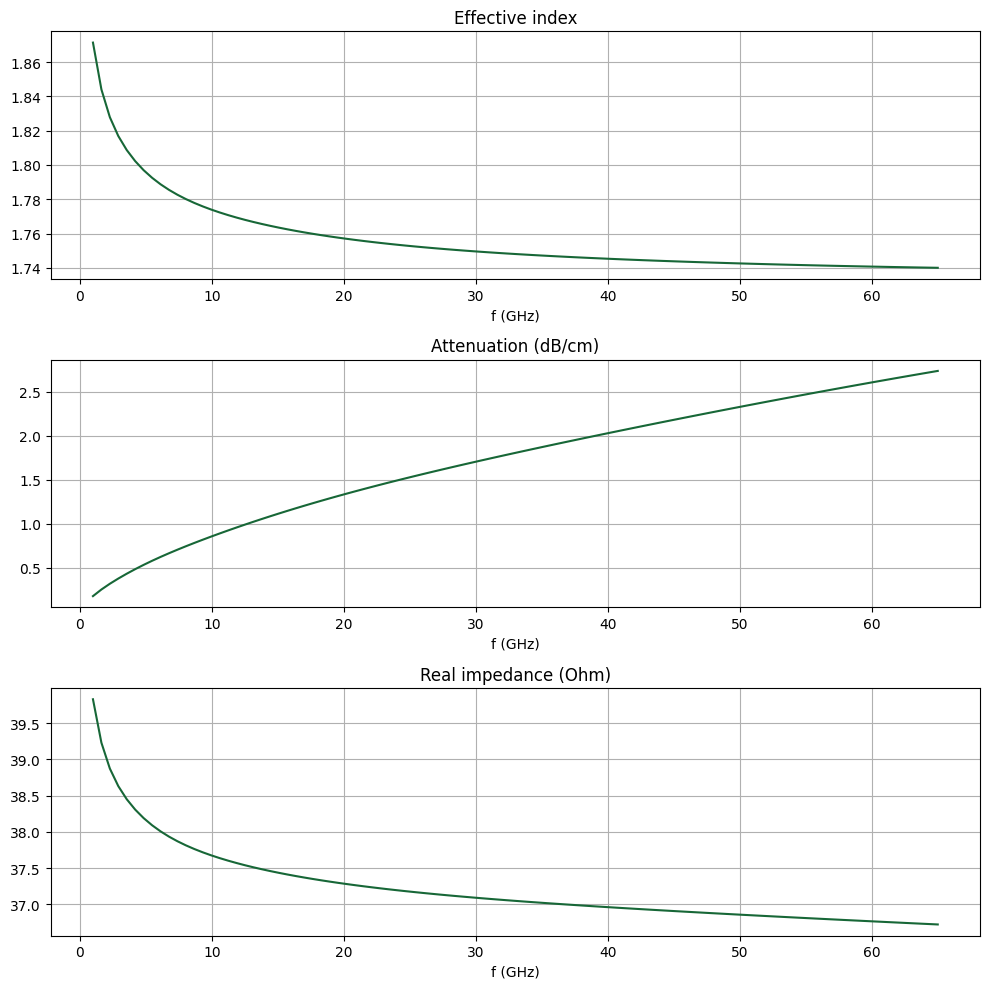

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10), tight_layout=True)
ax[0].set_title("Effective index")
ax[0].plot(freqs / 1e9, neff_mode)
ax[1].set_title("Attenuation (dB/cm)")
ax[1].plot(freqs / 1e9, alphadB_mode)
ax[2].set_title("Real impedance (Ohm)")
ax[2].plot(freqs / 1e9, np.real(Z0_mode))
for axis in ax:
    axis.grid()
    axis.set_xlabel("f (GHz)")
plt.show()

#### Distributed Transmission Line Parameters (RLCG)

Using the complex propagation constant $\gamma$ and the line impedance $Z_0$, we can calculate the RLCG parameters using the following relationships:
$$
  R = \text{Re}(\gamma Z_0), \quad L = \text{Im}(\gamma Z_0)/\omega, \quad G = \text{Re}(\gamma/Z_0), \quad C = \text{Im}(\gamma/Z_0)/\omega
$$
where $\omega = 2\pi f$.

In [23]:
R_mode = np.real(gamma_mode * Z0_mode)  # Ohm/um
G_mode = np.real(gamma_mode / Z0_mode)  # S/um
L_mode = np.imag(gamma_mode * Z0_mode) / (2 * np.pi * freqs)  # H/um
C_mode = np.imag(gamma_mode / Z0_mode) / (2 * np.pi * freqs)  # F/um

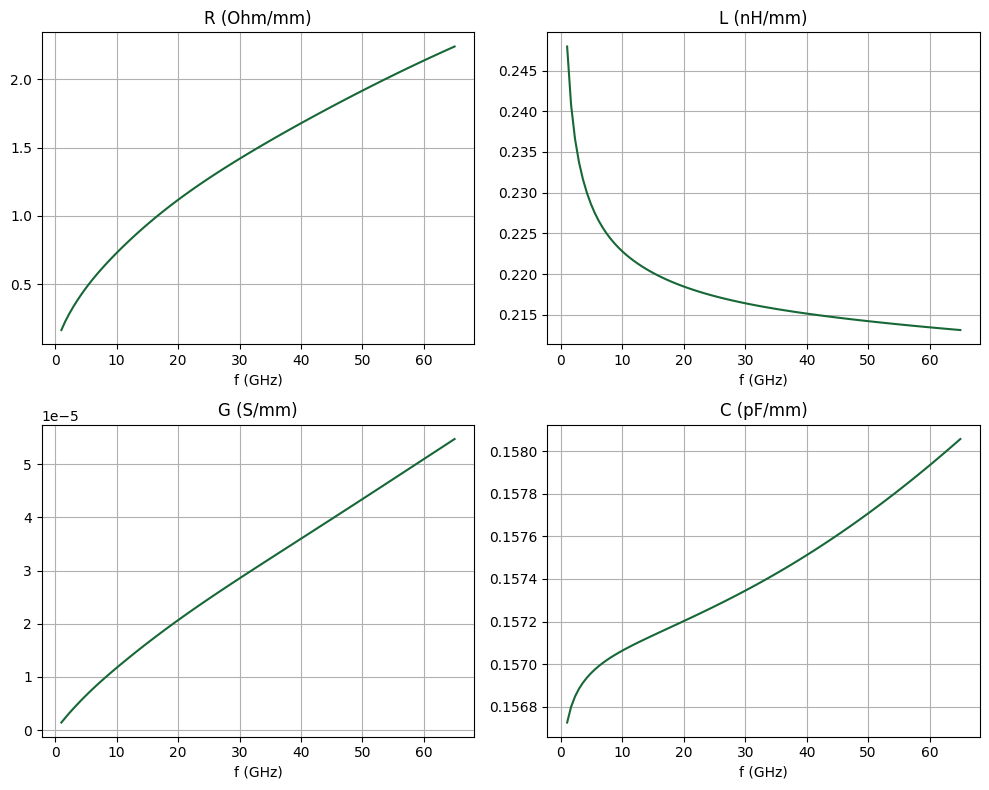

In [24]:
# Plot RLCG
fig, ax = plt.subplots(2, 2, figsize=(10, 8), tight_layout=False)
ax[0, 0].plot(freqs / 1e9, R_mode * 1e3)
ax[0, 1].plot(freqs / 1e9, L_mode * 1e12)
ax[1, 0].plot(freqs / 1e9, G_mode * 1e3)
ax[1, 1].plot(freqs / 1e9, C_mode * 1e15)
titles = ["R (Ohm/mm)", "L (nH/mm)", "G (S/mm)", "C (pF/mm)"]
for ii, title in enumerate(titles):
    ax[ii // 2, ii % 2].set_title(title)
    ax[ii // 2, ii % 2].set_xlabel("f (GHz)")
    ax[ii // 2, ii % 2].grid()
plt.show()

## Segmented Electrodes (3D analysis)

### Geometry

<center><img src="./img/cpw_rf_photonics_2_schematic2.png" width=800/></center>

The T-electrode geometry parameters are defined below. The rest of the dimensions are identical to those defined previously. Because the segmented CPW is longitudinally inhomogeneous, we will be using short sections of conventional CPW on both ends to excite the structure. 

In [25]:
# Define T-electrode dimensions
s, r = (2, 45)  # width and length, top of T
h, t = (6, 2)  # width and length, neck of T
c = 5  # gap between T units
P = r + c  # T electrode period
gw = g + 2 * (s + h)  # CPW gap including electrodes

# Define line lengths
LTL = 20 * P  # Length of segmented line
Lin = 5 * P  # CPW length, input section
Lout = 5 * P  # CPW length, output section

We make use of parameterized functions to create the T-electrode and segmented CPW. 

In [26]:
def create_T_structure(base_position, direction, width_r, width_t, width_s, width_h):
    """Create a T-shaped electrode"""
    x0, y0 = base_position
    sgn = 1 if direction == "+" else -1

    geom_T = [
        td.Box(
            size=(width_s, width_r, tm),
            center=(x0 + sgn * (width_h + width_s / 2), y0, tln0 - tln1 + tsio21 + tm / 2.0),
        ),
        td.Box(
            size=(width_h, width_t, tm),
            center=(x0 + sgn * width_h / 2, y0, tln0 - tln1 + tsio21 + tm / 2.0),
        ),
    ]

    return geom_T

In [27]:
def create_segmented_cpw(r, t, s, h, g, ws, P, L):
    """Creates segmented CPW and optical waveguide core/cladding"""
    gw = g + 2 * (s + h)  # CPW gap including electrodes

    # Optical WG Core + Cladding
    wg_core = create_rib_structure(
        w0, tln0 - tln1, thetaln, ((ws + gw) / 2, tln0 - tln1 / 2.0), med_LN
    )
    wg_clad = create_rib_structure(
        1.2 * w0, tln0 - tln1, thetaln, ((ws + gw) / 2, tln0 - tln1 / 2.0 + tsio21), med_SiO2
    )

    # Wide CPW in segmented section
    cpw_list_wide = create_cpw(gw, ws, wg - (s + h), tm, -len_inf, len_inf)

    # Narrow CPW for input/output section
    cpw_list_narrow = create_cpw(g, ws + 2 * (s + h), wg, tm, -len_inf, -L / 2) + create_cpw(
        g, ws + 2 * (s + h), wg, tm, L / 2, len_inf
    )

    # T-segments
    num_units = int(L / P)
    T_geom_list = []
    for ii in range(num_units + 1):
        xx0, xx1, xx2, xx3 = (-ws / 2 - gw, -ws / 2, ws / 2, ws / 2 + gw)
        yy = -P * num_units / 2 + (ii) * P
        T_geom_list += create_T_structure((xx0, yy), "+", r, t, s, h)
        T_geom_list += create_T_structure((xx1, yy), "-", r, t, s, h)
        T_geom_list += create_T_structure((xx2, yy), "+", r, t, s, h)
        T_geom_list += create_T_structure((xx3, yy), "-", r, t, s, h)
    T_structure = td.Structure(medium=med_Au, geometry=td.GeometryGroup(geometries=T_geom_list))

    return [wg_core, wg_clad, T_structure] + cpw_list_wide + cpw_list_narrow


# Create segmented CPW
structures_cpw_segmented = create_segmented_cpw(r, t, s, h, g, ws, P, LTL)

# Combine list of structures
structures_list_cpw_segmented = structures_layers + structures_cpw_segmented

### Grid and Boundary

The simulation size is defined below. 

In [28]:
# Simulation dimensions
sim_size = (sim_LX, LTL + Lin + Lout, sim_LZ)
sim_center = (0, -(Lin - Lout) / 2, 0)

We use the same grid refinement strategy as before. For 3D simulation, usually a lower level of refinement is necessary to achieve converged S-parameter results. 

In [29]:
# Layer refinement around conductors
LR_spec_2 = td.LayerRefinementSpec(
    center=(0, 0, 1),
    size=(td.inf, td.inf, 1),
    axis=2,
    corner_refinement=td.GridRefinement(dl=tm, num_cells=2),
    refinement_inside_sim_only=False,
)

refine_box_2 = td.MeshOverrideStructure(
    geometry=td.Box(center=((ws + gw) / 2, 0, (tln1) / 2), size=(1.2 * w0, td.inf, (tln1))),
    dl=(w0 / 5.0, None, tln0 / 2),
)

In [30]:
# Define grid spec
grid_spec_2 = td.GridSpec.auto(
    wavelength=td.C_0 / f_max,
    min_steps_per_wvl=20,
    override_structures=[refine_box_2],
    layer_refinement_specs=[LR_spec_2],
)

### Wave Ports and Monitors

The two wave ports are positioned along the input and output sections of the conventional CPW with a 100 micron spacing to the segmented structure.  

In [31]:
wp_offset = 100  # wave port offset

# Define current integral path
I_int = mw.CurrentIntegralAxisAligned(
    center=(0, -LTL / 2 - wp_offset, 1),
    size=(ws + gw, 0, 5 * tm),
    sign="+",
)

# Define wave ports
WP1 = sm.WavePort(
    name="WP1",
    center=(0, -LTL / 2 - wp_offset, 1),
    size=wp_size,
    mode_spec=td.ModeSpec(target_neff=np.sqrt(8)),
    direction="+",
    current_integral=I_int,
    # frame=None
)
WP2 = WP1.updated_copy(
    name="WP2",
    center=(0, LTL / 2 + wp_offset, 0),
    direction="-",
    current_integral=I_int.updated_copy(center=(0, LTL / 2 + wp_offset, 1), sign="-"),
)

We define a field monitor for visualization purposes. 

In [32]:
# Define monitors
mon_field1 = td.FieldMonitor(
    center=(0, 0, 1),
    size=(w_cpw, len_inf, 0),
    freqs=[f_min, f0, f_max],
    name="field cpw plane",
)

monitors_list = [mon_field1]

### Define Simulation and `TerminalComponentModeler`

In [33]:
# Define base simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec_2,
    structures=structures_list_cpw_segmented,
    monitors=monitors_list,
    run_time=2e-10,
    symmetry=(1, 0, 0),
)

In [34]:
# Define TerminalComponentModeler
tcm = sm.TerminalComponentModeler(
    simulation=sim,
    ports=[WP1, WP2],
    freqs=freqs,
)

### Visualization

We plot the transverse and longitudinal cross sections to check that the structures and grid are properly set up. 

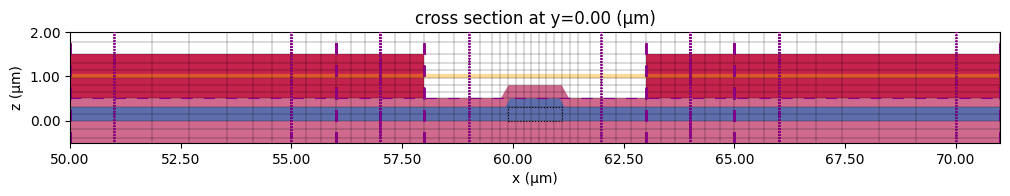

In [35]:
# Plot structure/grid in CPW gap
fig, ax = plt.subplots(figsize=(12, 4))
sim.plot(y=0, ax=ax)
sim.plot_grid(y=0, ax=ax, hlim=(ws / 2, ws / 2 + gw), vlim=(-0.5, 2))
plt.show()

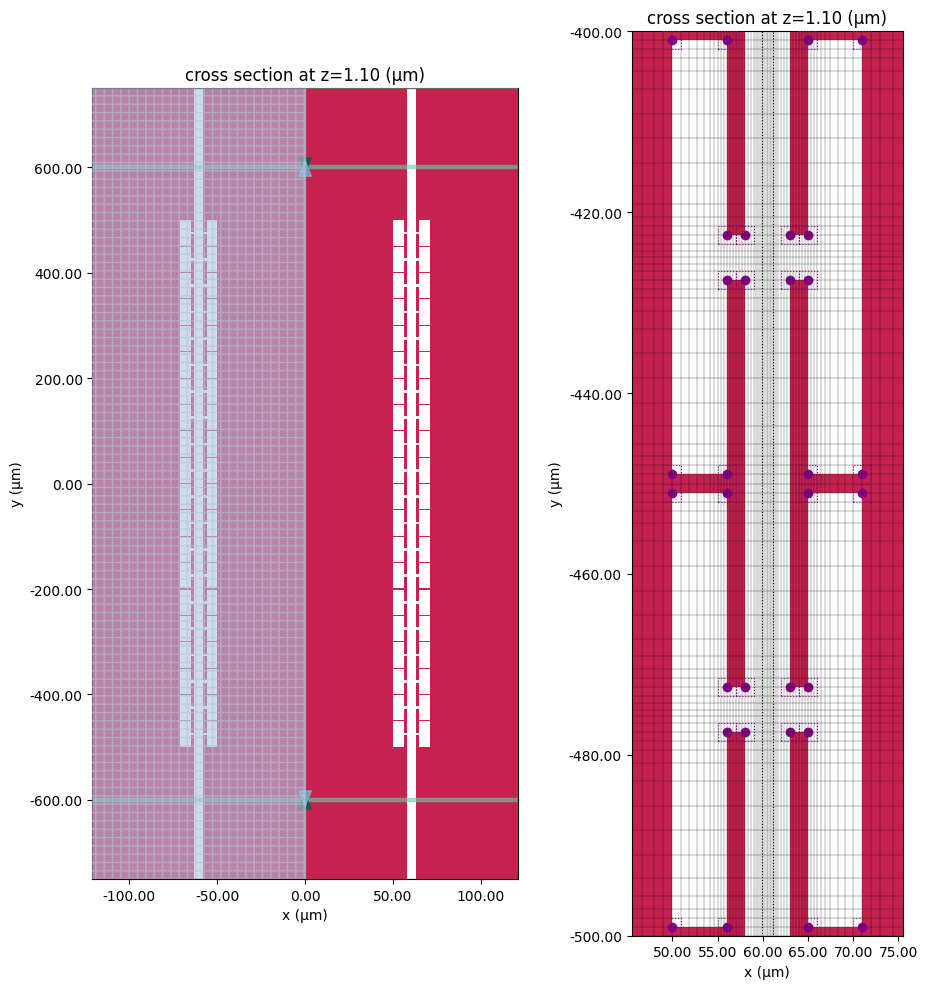

In [36]:
# Plot structure/grid in metal plane
fig, ax = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
tcm.plot_sim(
    z=1.1,
    ax=ax[0],
    hlim=(-gw - ws, gw + ws),
    vlim=(-LTL / 2 - Lin, LTL / 2 + Lout),
)
# sim.plot_grid(z=1.1, hlim=(-gw-ws, gw+ws), vlim=(-LTL/2-Lin,LTL/2+Lout), ax=ax[0])
ax[0].set_aspect(0.3)

tcm.plot_sim(z=1.1, ax=ax[1])
sim.plot_grid(
    z=1.1,
    hlim=((gw + ws) / 2 - 15, (gw + ws) / 2 + 15),
    vlim=(-LTL / 2, -LTL / 2 + 2 * P),
    ax=ax[1],
)
plt.show()

### Run Simulation

In [37]:
tcm_data = td.web.run(tcm, task_name="segmented cpw", path="data/segmented_cpw.hdf5")

10:14:28 EDT Created task 'segmented cpw' with resource_id                      
             'sid-54b84d4a-e8a9-4029-9763-1efef4a8898f' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=618170;https://tidy3d.simulation.cloud/rf?taskId=pa-47657bc0-73a6-4094-a1b6-821c026e62dd\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=157188;https://tidy3d.simulation.cloud/rf?taskId=pa-47657bc0-73a6-4094-a1b6-821c026e62dd\taskId]8;;\]8;id=618170;https://tidy3d.simulation.cloud/rf?taskId=pa-47657bc0-73a6-4094-a1b6-821c026e62dd\=]8;;\]8;id=804973;https://tidy3d.simulation.cloud/rf?taskId=pa-47657bc0-73a6-4094-a1b6-821c026e62dd\pa]8;;\]8;id=618170;https://tidy3d.simulation.cloud/rf?taskId=pa-47657bc0-73a6-4094-a1b6-821c026e62dd\-47657bc0-73a6-4094-a1]8;;\
             ]8;id=618170;https://tidy3d.simulation.cloud/rf?taskId=pa-47657bc0-73a6-4094-a1b6-821c026e62dd\b6-821c026e62dd']8;;\.

             Task folder: ]8;id=686576;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

10:14:38 EDT Child simulation subtasks are being uploaded to                    
             - WP2@0: 'rf-a4423ac0-26c4-4563-82ea-42e83c39c6db'                 
             - WP1@0: 'rf-f2691f35-e0d5-4583-b71e-53c5a3fbe275'

10:14:41 EDT Validating component modeler and subtask simulations...

             Maximum FlexCredit cost: 5.924. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Component modeler batch validation has been successful.

10:14:42 EDT Subtasks status - segmented cpw                                    
             Group ID: 'pa-47657bc0-73a6-4094-a1b6-821c026e62dd'

Output()

10:19:00 EDT Modeler has finished running successfully.

             Billed FlexCredit cost: 3.581. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

10:19:12 EDT loading component modeler data from data/segmented_cpw.hdf5

### Results

#### Field Profile

First, let us take a look at the field monitor data. The field magnitude in the CPW gap is shown below. 

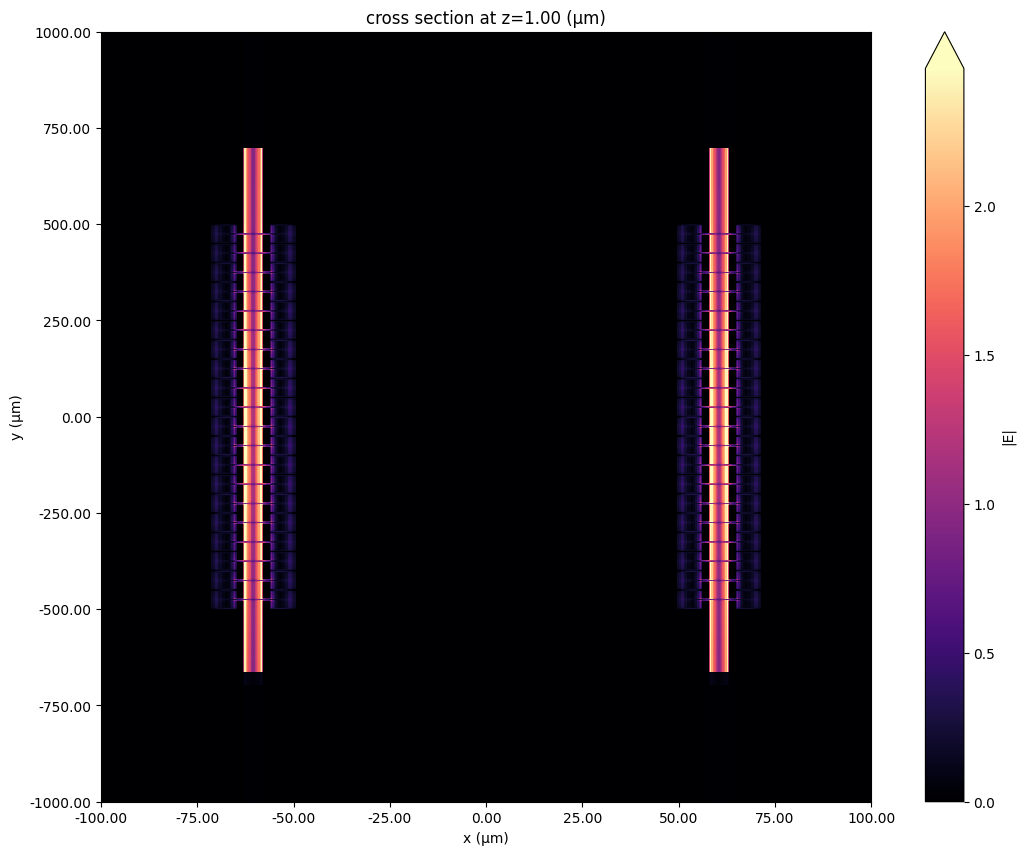

In [38]:
# Load simulation data from TCM data
sim_data = tcm_data.data["WP1@0"]

# longitudinal field
fig, ax = plt.subplots(figsize=(14, 10))
f_plot = f_max
sim_data.plot_field("field cpw plane", field_name="E", val="abs", ax=ax, f=f_plot)
ax.set_xlim(-100, 100)
ax.set_ylim(-1000, 1000)
ax.set_aspect(0.1)
plt.show()

#### S-parameters

The S-matrix can be calculated using the `smatrix()` method. We also define several convenience functions to get a specific `S_ij` in different formats. 

In [39]:
# Calculate S-matrix dataset
smat = tcm_data.smatrix()


# Convenience functions
def sparam(i, j):
    return np.conjugate(smat.data.isel(port_in=j - 1, port_out=i - 1))


def sparam_abs(i, j):
    return np.abs(sparam(i, j))


def sparam_dB(i, j):
    return 20 * np.log10(sparam_abs(i, j))

For comparison purposes, we import benchmark data from a commercial FEM solver. 

In [40]:
# Import benchmark data
freqs_ben, S21abs_ben, S11abs_ben = np.genfromtxt(
    "misc/seg_fem_sparam.csv", skip_header=1, delimiter=",", unpack=True
)

The return and insertion loss magnitudes are compared below. We find a good overall match. We also note a considerable speed improvement using the Tidy3D RF solver (approx. 3.5 minutes) versus conventional FEM (approx. 1.5 hours).

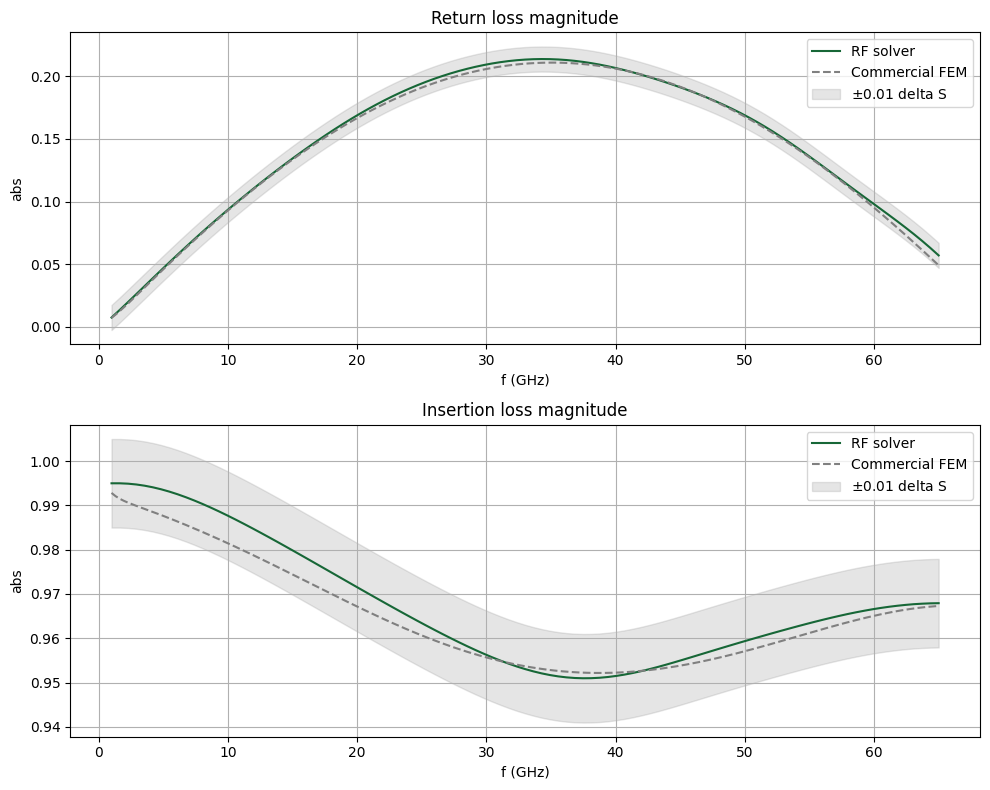

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), tight_layout=True)
delta_S = 0.01
ax[0].set_title("Return loss magnitude")
ax[0].plot(freqs / 1e9, sparam_abs(1, 1), label="RF solver")
ax[0].plot(freqs_ben, S11abs_ben, "--", color="gray", label="Commercial FEM")
ax[0].fill_between(
    freqs / 1e9,
    sparam_abs(1, 1) - delta_S,
    sparam_abs(1, 1) + delta_S,
    color="gray",
    alpha=0.2,
    label="$\\pm$0.01 delta S",
)

ax[1].set_title("Insertion loss magnitude")
ax[1].plot(freqs / 1e9, sparam_abs(2, 1), label="RF solver")
ax[1].plot(freqs_ben, S21abs_ben, "--", color="gray", label="Commercial FEM")
ax[1].fill_between(
    freqs / 1e9,
    sparam_abs(2, 1) - delta_S,
    sparam_abs(2, 1) + delta_S,
    color="gray",
    alpha=0.2,
    label="$\\pm$0.01 delta S",
)
for axis in ax:
    axis.legend()
    axis.grid()
    axis.set_xlabel("f (GHz)")
    axis.set_ylabel("abs")
plt.show()

## Conclusion

In this notebook, we studied the CPW in the context of a Mach-Zehnder modulator. We simulated two different configurations, namely the conventional straight CPW and segmented electrodes design, and obtained key transmission line parameters. 